In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics.pairwise import cosine_similarity
from keras.applications import vgg16
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input

In [2]:
imgs_path = ".style/"
imgs_model_width, imgs_model_height = 224, 224

nb_closest_images = 5  # number of most similar images to retrieve

In [3]:
# 이미지를 활용한 추천을 하기 때문에 CNN모델이 필요함
# VGG16 모델 로드
# 예측 대신 feature를 가져오기 위해 마지막 레이어는 제거
# load the model
vgg_model = vgg16.VGG16(weights='imagenet')

# remove the last layers in order to get features instead of predictions
feat_extractor = Model(inputs=vgg_model.input,
                       outputs=vgg_model.get_layer("fc2").output)

# print the layers of the CNN
feat_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
# 이미지 경로에 있는 사진 수 출력
files = [imgs_path + x for x in os.listdir(imgs_path) if "png" in x]

print("number of images:", len(files))

number of images: 2184


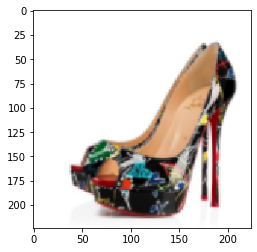

image loaded successfully!


In [5]:
# 샘플 이미지 출력
# load an image in PIL format
original = load_img(files[0],
                    target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("image loaded successfully!")

In [6]:
# PIL모듈로 불러온 이미지를 numpy로 변환 후 데이터 전처리
# 차원 확장 (224, 224, 3) -> (1, 224, 224, 3)
# VGG16 모델에 맞춰 데이터 전처리
# convert the PIL image to a numpy array
# in PIL - image is in (width, height, channel)
# in Numpy - image is in (height, width, channel)
numpy_image = img_to_array(original)

# convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# we want the input matrix to the network to be of the form (batchsize, height, width, channels)
# thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)

# prepare the image for the VGG model
processed_image = preprocess_input(image_batch.copy())

image batch size (1, 224, 224, 3)


In [7]:
# 이미지 feature 추출하기
# get the extracted features
img_features = feat_extractor.predict(processed_image)

print("features successfully extracted!")
print("number of image features:", img_features.size)
img_features

features successfully extracted!
number of image features: 4096


array([[0.      , 0.      , 0.982901, ..., 1.664278, 0.      , 0.      ]],
      dtype=float32)

In [8]:
# 모든 이미지 파일 데이터 전처리
# load all the images and prepare them for feeding into the CNN
importedImages = []

for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)

    importedImages.append(image_batch)

images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [9]:
# 불러온 모든 이미지에 대한 feature 추출
# extract the images features

imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape

features successfully extracted!


(2184, 4096)

In [10]:
# 이미지들 간 코사인 유사도 계산하기
# compute cosine similarities between images

cosSimilarities = cosine_similarity(imgs_features)

# store the results into a pandas dataframe

cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df.head()

,.style/0_0_001.png,.style/0_0_002.png,.style/0_0_003.png,.style/0_0_004.png,.style/0_0_005.png,.style/0_0_006.png,.style/0_0_007.png,.style/0_0_008.png,.style/0_0_009.png,.style/0_0_010.png,...,.style/6_9_012.png,.style/6_9_013.png,.style/6_9_014.png,.style/6_9_015.png,.style/6_9_016.png,.style/6_9_017.png,.style/6_9_018.png,.style/6_9_019.png,.style/6_9_020.png,.style/6_9_021.png
.style/0_0_001.png,1.000000,0.554049,0.558604,0.569180,0.521653,0.592047,0.503104,0.587524,0.352379,0.402149,...,0.301026,0.259110,0.247525,0.354845,0.276685,0.399455,0.215229,0.263327,0.362407,0.295146
.style/0_0_002.png,0.554049,1.000000,0.352109,0.421502,0.522087,0.451603,0.321063,0.683552,0.364152,0.295509,...,0.285045,0.265266,0.204261,0.326135,0.348535,0.518808,0.210399,0.309722,0.334927,0.271468
.style/0_0_003.png,0.558604,0.352109,1.000000,0.818587,0.382179,0.444817,0.624104,0.450201,0.348389,0.279833,...,0.403509,0.339665,0.243405,0.399804,0.352435,0.292412,0.251002,0.329948,0.379237,0.276603
.style/0_0_004.png,0.569180,0.421502,0.818587,1.000000,0.416594,0.525981,0.636028,0.499594,0.374052,0.305753,...,0.345941,0.351294,0.293236,0.341904,0.342104,0.295217,0.220415,0.323897,0.377293,0.299915
.style/0_0_005.png,0.521653,0.522087,0.382179,0.416594,1.000000,0.473533,0.325206,0.599164,0.506743,0.393803,...,0.254234,0.241993,0.264280,0.371291,0.313428,0.401388,0.157732,0.258895,0.314457,0.281423


In [11]:
def retrieve_most_similar_products(given_img):
    # function to retrieve the most similar products for a given one
    # 유사한 이미지 가져오는 함수 정의

    print(
        "-----------------------------------------------------------------------"
    )
    print("original product:")

    original = load_img(given_img,
                        target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print(
        "-----------------------------------------------------------------------"
    )
    print("most similar products:")

    closest_imgs = cos_similarities_df[given_img].sort_values(
        ascending=False)[1:nb_closest_images + 1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(
        ascending=False)[1:nb_closest_images + 1]

    for i in range(0, len(closest_imgs)):
        original = load_img(closest_imgs[i],
                            target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("similarity score : ", closest_imgs_scores[i])

-----------------------------------------------------------------------
original product:


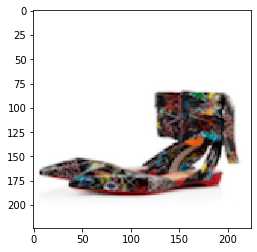

-----------------------------------------------------------------------
most similar products:


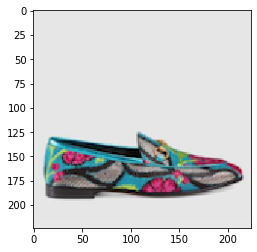

similarity score :  0.69048274


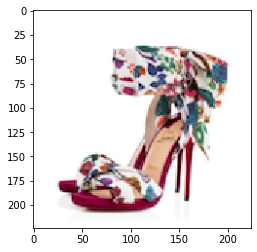

similarity score :  0.68355215


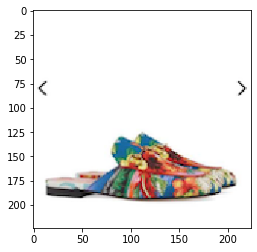

similarity score :  0.6741034


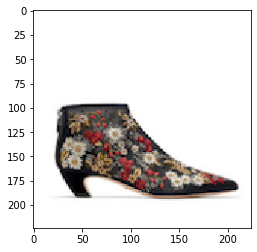

similarity score :  0.6623959


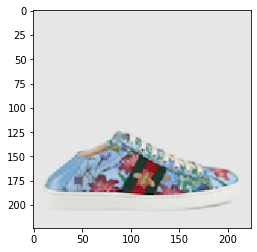

similarity score :  0.6486194


In [12]:
retrieve_most_similar_products(files[1])

-----------------------------------------------------------------------
original product:


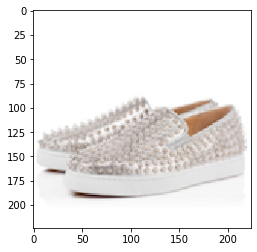

-----------------------------------------------------------------------
most similar products:


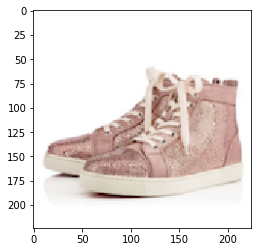

similarity score :  0.8185874


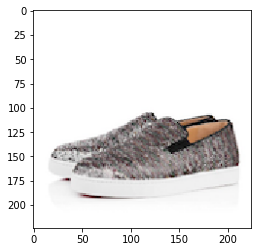

similarity score :  0.7910199


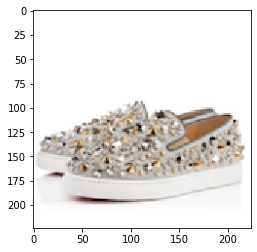

similarity score :  0.7794864


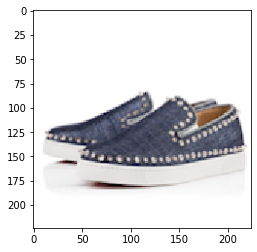

similarity score :  0.7775078


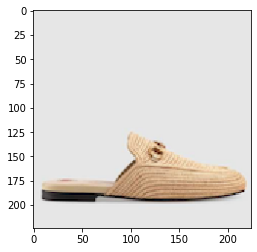

similarity score :  0.7718187


In [13]:
retrieve_most_similar_products(files[2])

-----------------------------------------------------------------------
original product:


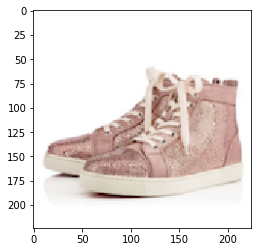

-----------------------------------------------------------------------
most similar products:


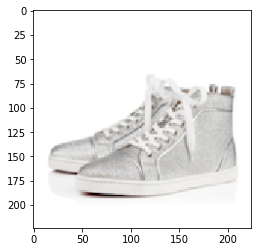

similarity score :  0.84425676


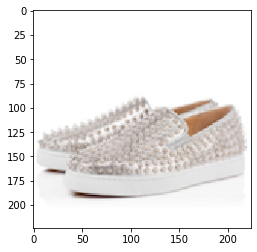

similarity score :  0.8185874


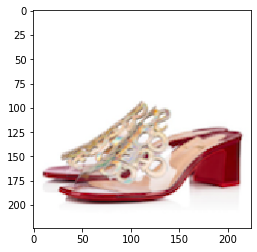

similarity score :  0.78434336


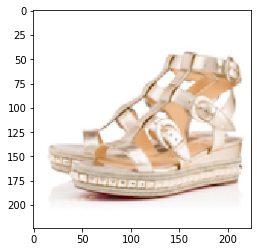

similarity score :  0.76203626


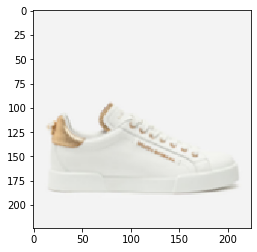

similarity score :  0.75386745


In [14]:
retrieve_most_similar_products(files[3])

-----------------------------------------------------------------------
original product:


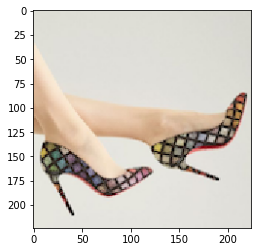

-----------------------------------------------------------------------
most similar products:


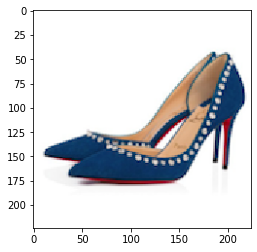

similarity score :  0.623359


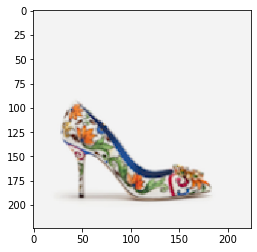

similarity score :  0.60832095


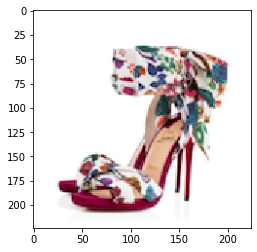

similarity score :  0.59916365


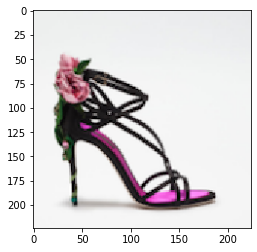

similarity score :  0.58676827


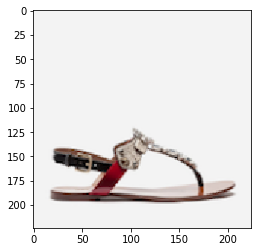

similarity score :  0.58369017


In [15]:
retrieve_most_similar_products(files[4])

-----------------------------------------------------------------------
original product:


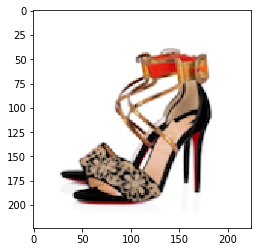

-----------------------------------------------------------------------
most similar products:


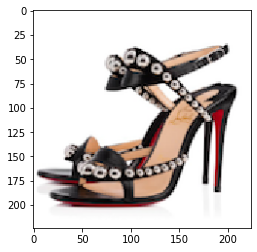

similarity score :  0.7263939


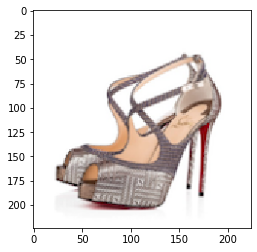

similarity score :  0.6769768


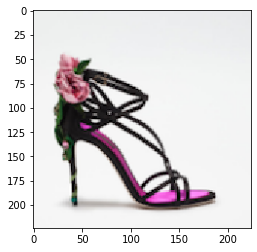

similarity score :  0.6681956


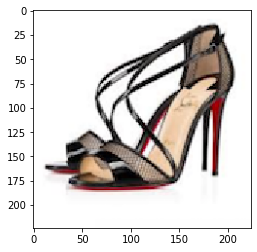

similarity score :  0.66704446


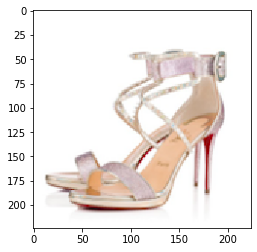

similarity score :  0.65715885


In [16]:
retrieve_most_similar_products(files[5])